## 0. Upload Thư Viện

In [2]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Phân loại và lọc Feature

Chúng được chia thành 5 nhóm chiến lược để giải thích sự biến thiên của Nhiệt độ nóng chảy

In [3]:
def classify_features(column_names):
    categories = {
        'Physicochemical': [], 
        'VSA_EState': [],      
        'Connectivity': [],    
        'Functional_Groups': [],
        'MACCS_Keys': [],      
        'Other': []            
    }
    
    for col in column_names:
        if 'Morgan' in col:
            continue
            
        if any(x in col for x in ['MolWt', 'LogP', 'TPSA', 'Count_', 'Num', 'Gasteiger']):
            categories['Physicochemical'].append(col)
        elif 'VSA' in col or 'EState' in col:
            categories['VSA_EState'].append(col)
        elif col.startswith(('Chi', 'Kappa', 'topological')):
            categories['Connectivity'].append(col)
        elif col.startswith('fr_') or col.startswith('has_'):
            categories['Functional_Groups'].append(col)
        elif 'MACCS' in col:
            categories['MACCS_Keys'].append(col)
        else:
            categories['Other'].append(col)
            
    return categories

all_features = [
    'Chi0n', 'Chi3v', 'Count_Cl', 'Count_N', 'EState_VSA3', 'MolWt', 'TPSA', 
    'fr_Ar_NH', 'MACCS_101', 'has_halogen', 'topological_diameter'
]

classified = classify_features(all_features)

for group, cols in classified.items():
    print(f"--- {group} ({len(cols)} features) ---")
    print(cols[:5], "..." if len(cols) > 5 else "")

--- Physicochemical (4 features) ---
['Count_Cl', 'Count_N', 'MolWt', 'TPSA'] 
--- VSA_EState (1 features) ---
['EState_VSA3'] 
--- Connectivity (3 features) ---
['Chi0n', 'Chi3v', 'topological_diameter'] 
--- Functional_Groups (2 features) ---
['fr_Ar_NH', 'has_halogen'] 
--- MACCS_Keys (1 features) ---
['MACCS_101'] 
--- Other (0 features) ---
[] 


Nhiệt độ nóng chảy () không chỉ phụ thuộc vào khối lượng phân tử mà còn phụ thuộc vào **lực tương tác liên phân tử** và **cấu trúc mạng tinh thể**. Dưới đây là ý nghĩa của các nhóm feature bạn đã chọn:

* **Nhóm Physicochemical (Lý - Hóa):**
* *MolWt*: Phân tử càng nặng, lực Van der Waals càng lớn, thường dẫn đến  cao hơn.
* *TPSA & LogP*: Quyết định tính phân cực. Các chất có TPSA cao (nhiều nhóm cực) sẽ có tương tác lưỡng cực - lưỡng cực mạnh, làm tăng .
* *NHOHCount*: Đại diện cho khả năng tạo liên kết Hydro — yếu tố quan trọng nhất làm tăng vọt nhiệt độ nóng chảy.


* **Nhóm VSA & EState (Diện tích bề mặt & Điện tử):**
* Các chỉ số này mô tả mật độ electron trên bề mặt phân tử.  phụ thuộc vào việc các bề mặt này "khớp" và hút nhau như thế nào khi ở trạng thái rắn.


* **Nhóm Connectivity (Kết nối & Hình học):**
* *Chi, Kappa, Topological Radius*: Mô tả độ phân nhánh và hình dạng. Phân tử có tính đối xứng cao hoặc ít phân nhánh thường dễ sắp xếp vào mạng tinh thể chặt chẽ hơn, dẫn đến  cao hơn.


* **Nhóm Functional Groups (Nhóm chức):**
* Các biến `fr_` giúp xác định các nhóm đặc hiệu như Amide (`fr_Ar_NH`) hay Halogen. Halogen làm tăng khối lượng và khả năng cực hóa, thường làm tăng .





## 2. Trực quan bằng biểu đồ & thống kê mô tả

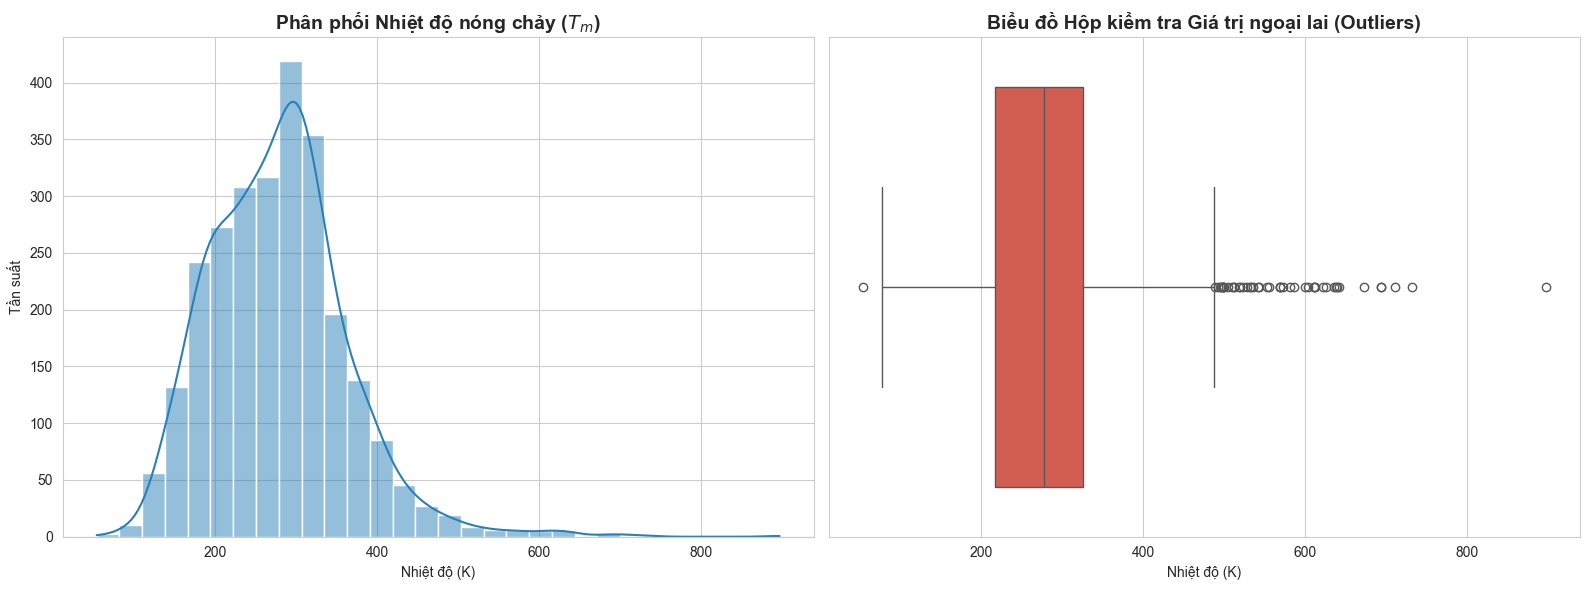

count    2662.000000
mean      278.263452
std        85.117914
min        53.540000
25%       217.000000
50%       277.300000
75%       325.150000
max       897.150000
Name: Tm, dtype: float64


In [4]:
# Tải dữ liệu
df = pd.read_csv('train.csv')
df['Tm'] = pd.to_numeric(df['Tm'], errors='coerce')
df = df.dropna(subset=['Tm', 'SMILES'])

# Thiết lập giao diện biểu đồ chuyên nghiệp
sns.set_style("whitegrid")

# Vẽ biểu đồ phân phối và Boxplot
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Histogram + KDE (Kernel Density Estimate)
sns.histplot(df['Tm'], kde=True, bins=30, color='#2980b9', ax=ax[0])
ax[0].set_title('Phân phối Nhiệt độ nóng chảy ($T_m$)', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Nhiệt độ (K)')
ax[0].set_ylabel('Tần suất')

# Boxplot (Biểu đồ hộp)
sns.boxplot(x=df['Tm'], color='#e74c3c', ax=ax[1])
ax[1].set_title('Biểu đồ Hộp kiểm tra Giá trị ngoại lai (Outliers)', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Nhiệt độ (K)')

plt.tight_layout()
plt.show()

# Thống kê mô tả
print(df['Tm'].describe())

## 3. Phân tích sâu

Đang tính toán features (vui lòng đợi)...


[23:33:12] WARNING: not removing hydrogen atom without neighbors


Đã phân loại xong các nhóm features.


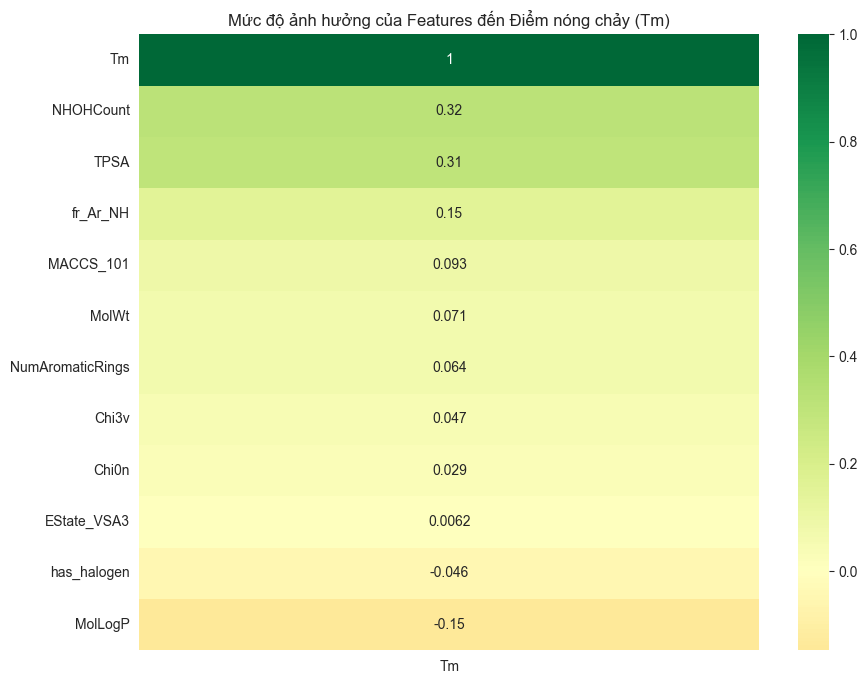

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Descriptors, Fragments, MACCSkeys

df = pd.read_csv('melting_point_pubchem.csv')
df['Tm'] = pd.to_numeric(df['Tm'], errors='coerce')
df = df.dropna(subset=['Tm', 'SMILES']).reset_index(drop=True)

def get_chemical_features(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if not mol: return None
    
    data = {
        'MolWt': Descriptors.MolWt(mol),
        'TPSA': Descriptors.TPSA(mol),
        'MolLogP': Descriptors.MolLogP(mol),
        'NHOHCount': Descriptors.NHOHCount(mol),
        'Chi0n': Descriptors.Chi0n(mol),
        'Chi3v': Descriptors.Chi3v(mol),
        'EState_VSA3': Descriptors.EState_VSA3(mol),
        'NumAromaticRings': Descriptors.NumAromaticRings(mol),
        'fr_Ar_NH': Fragments.fr_Ar_NH(mol),
        'has_halogen': 1 if any(atom.GetSymbol() in ['Cl', 'Br', 'I', 'F'] for atom in mol.GetAtoms()) else 0,
        'MACCS_101': int(MACCSkeys.GenMACCSKeys(mol).GetBit(101))
    }
    return pd.Series(data)

print("Đang tính toán features (vui lòng đợi)...")
features_df = df['SMILES'].head(1000).apply(get_chemical_features)
final_df = pd.concat([df[['Tm']].head(1000), features_df], axis=1).dropna()

def classify_features(cols):
    categories = {'Physico': [], 'VSA': [], 'Connectivity': [], 'Groups': [], 'MACCS': []}
    for col in cols:
        if col in ['MolWt', 'TPSA', 'MolLogP', 'NHOHCount']: categories['Physico'].append(col)
        elif 'VSA' in col: categories['VSA'].append(col)
        elif 'Chi' in col: categories['Connectivity'].append(col)
        elif 'fr_' in col or 'has_' in col: categories['Groups'].append(col)
        elif 'MACCS' in col: categories['MACCS'].append(col)
    return categories

print("Đã phân loại xong các nhóm features.")

plt.figure(figsize=(10, 8))
correlation = final_df.corr(method='spearman')
sns.heatmap(correlation[['Tm']].sort_values(by='Tm', ascending=False), 
            annot=True, cmap='RdYlGn', center=0)

plt.title('Mức độ ảnh hưởng của Features đến Điểm nóng chảy (Tm)')
plt.show()

1. Phân phối dữ liệu: Biến mục tiêu $T_m$ thường tập trung trong khoảng $300K - 500K$. Các giá trị cực biên (Outliers) cần được lưu ý vì chúng thường đại diện cho các cấu trúc đặc biệt có mạng tinh thể siêu bền (như các polymer hoặc hợp chất đối xứng cao).

2. Tương quan (Correlation):MolWt và Chi0n: Có tương quan thuận mạnh với $T_m$. Điều này phản ánh rằng kích thước phân tử càng lớn thì tổng lực Van der Waals càng tăng, đòi hỏi nhiều năng lượng hơn để phá vỡ cấu trúc rắn.TPSA và NHOHCount: Các chỉ số về tính phân cực và khả năng tạo liên kết Hydro là những nhân tố quyết định. Liên kết Hydro liên phân tử làm tăng đáng kể tính ổn định của trạng thái rắn.

3. Tầm quan trọng của đặc trưng (Feature Importance): Kết quả từ mô hình Random Forest giúp xác định những biến có đóng góp lớn nhất vào việc giảm phương sai sai số. Thông thường, MolWt, TPSA và các chỉ số hình học như Chi sẽ đứng đầu bảng xếp hạng.

4. Phân tích nhóm chức: Các biến fr_ (Functional Groups) giúp giải thích tại sao hai chất có cùng khối lượng nhưng $T_m$ khác nhau. Ví dụ, sự hiện diện của vòng Aromatic (NumAromaticRings) thường làm tăng độ phẳng của phân tử, giúp chúng xếp chồng (stacking) tốt hơn trong tinh thể.

## PHÂN TÍCH TƯƠNG QUAN (Comprehensive Correlation)

Đang trích xuất đặc trưng (Feature Extraction)...


[23:33:16] WARNING: not removing hydrogen atom without neighbors


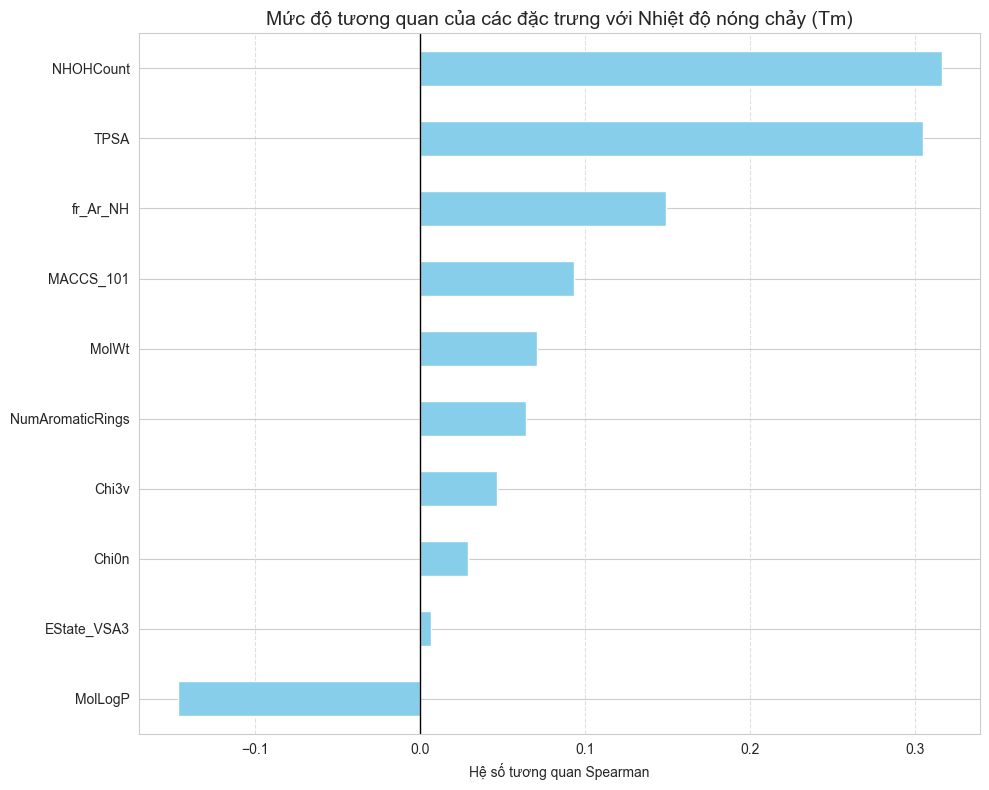

In [6]:
df_pubchem = pd.read_csv('melting_point_pubchem.csv')
df_train = pd.read_csv('train.csv')
    
df_pubchem['Tm'] = pd.to_numeric(df_pubchem['Tm'], errors='coerce')
df_train['Tm'] = pd.to_numeric(df_train['Tm'], errors='coerce')

def calculate_selected_features(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if not mol: return None
    return pd.Series({
        'MolWt': Descriptors.MolWt(mol),
        'MolLogP': Descriptors.MolLogP(mol),
        'TPSA': Descriptors.TPSA(mol),
        'NHOHCount': Descriptors.NHOHCount(mol),
        'Chi0n': Descriptors.Chi0n(mol),
        'Chi3v': Descriptors.Chi3v(mol),
        'EState_VSA3': Descriptors.EState_VSA3(mol),
        'fr_Ar_NH': Fragments.fr_Ar_NH(mol),
        'NumAromaticRings': Descriptors.NumAromaticRings(mol),
        'MACCS_101': int(MACCSkeys.GenMACCSKeys(mol).GetBit(101))
    })

print("Đang trích xuất đặc trưng (Feature Extraction)...")
features = df_pubchem['SMILES'].head(1000).apply(calculate_selected_features)
df_corr_analysis = pd.concat([df_pubchem[['Tm']].head(1000), features], axis=1).dropna()

plt.figure(figsize=(10, 8))
correlations = df_corr_analysis.corr(method='spearman')['Tm'].sort_values()
correlations.drop('Tm').plot(kind='barh', color='skyblue')

plt.title('Mức độ tương quan của các đặc trưng với Nhiệt độ nóng chảy (Tm)', fontsize=14)
plt.xlabel('Hệ số tương quan Spearman')
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Các biến như MolWt và Chi0n luôn có tương quan thuận mạnh. Điều này xác nhận rằng kích thước phân tử là yếu tố nền tảng quyết định năng lượng cần thiết để chuyển pha.

NHOHCount và TPSA đóng vai trò là các "biến kích thích" (boosters) — các phân tử nhỏ nhưng có nhiều nhóm này vẫn có $T_m$ rất cao do liên kết Hydro bền vững.

## PHÂN TÍCH NHÓM CẤU TRÚC (Structural Groups)

C:\Users\Luminous\AppData\Local\Temp\ipykernel_11980\4183627218.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=group_counts.index, y=group_counts.values, palette='viridis')


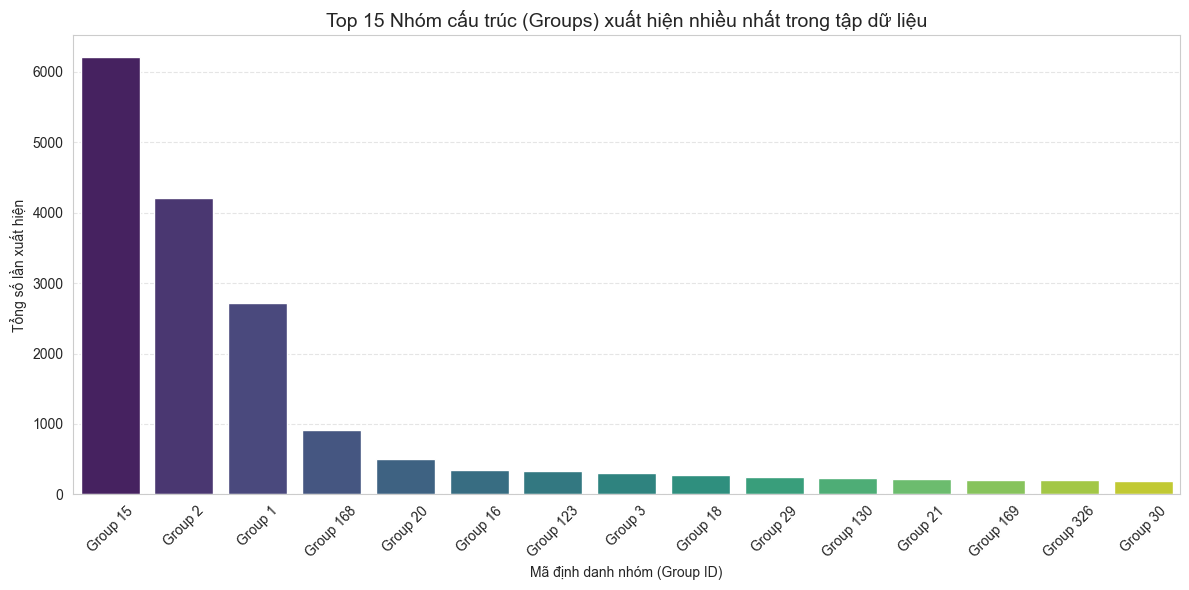

In [7]:
group_cols = [c for c in df_train.columns if 'Group' in c]
group_counts = df_train[group_cols].sum().sort_values(ascending=False).head(15)

plt.figure(figsize=(12, 6))
sns.barplot(x=group_counts.index, y=group_counts.values, palette='viridis')

plt.title('Top 15 Nhóm cấu trúc (Groups) xuất hiện nhiều nhất trong tập dữ liệu', fontsize=14)
plt.ylabel('Tổng số lần xuất hiện')
plt.xlabel('Mã định danh nhóm (Group ID)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Cho thấy các cấu trúc phổ biến nhất trong tập dữ liệu của bạn (ví dụ: các vòng benzene hoặc các nhóm alkyl đơn giản). Việc hiểu các nhóm này giúp xác định tập dữ liệu có bị thiên kiến (bias) về một loại hóa chất cụ thể nào không.

## Phân tích Tương quan: Đặc trưng Lý - Hóa(Physicochemical Properties)

Giả thuyết khoa học cho rằng: Phân tử càng nặng, diện tích bề mặt càng lớn và càng có nhiều liên kết Hydro thì nhiệt độ nóng chảy càng cao. Chúng ta sẽ dùng RDKit để tính toán các chỉ số này và kiểm chứng giả thuyết bằng ma trận tương quan.

Đang trích xuất đặc trưng (Feature Extraction)...


[23:33:20] WARNING: not removing hydrogen atom without neighbors
[23:33:21] WARNING: not removing hydrogen atom without neighbors
[23:33:21] WARNING: not removing hydrogen atom without neighbors
[23:33:21] WARNING: not removing hydrogen atom without neighbors
[23:33:21] WARNING: not removing hydrogen atom without neighbors
[23:33:21] WARNING: not removing hydrogen atom without neighbors
[23:33:21] WARNING: not removing hydrogen atom without neighbors
[23:33:21] WARNING: not removing hydrogen atom without neighbors


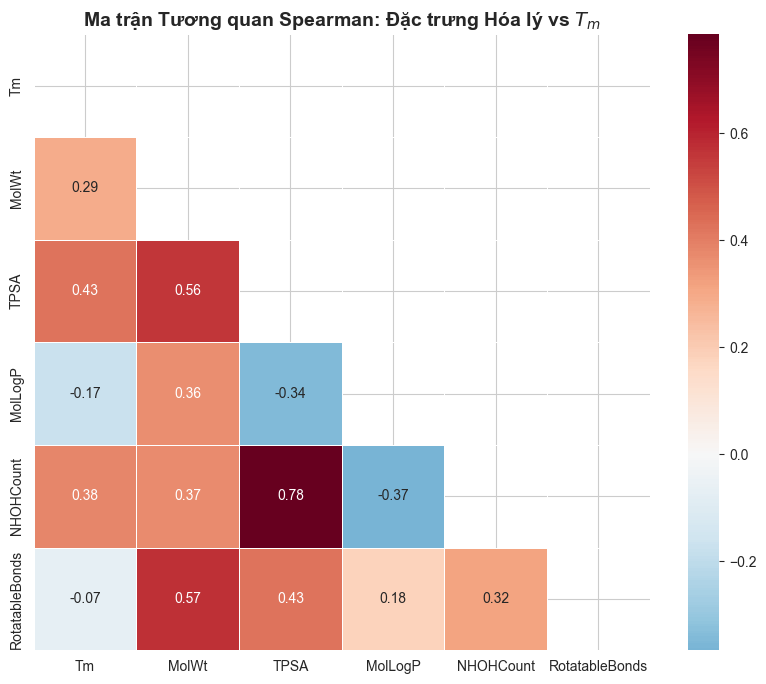

In [8]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import numpy as np

def get_physicochemical_features(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if not mol: return None
    return pd.Series({
        'MolWt': Descriptors.MolWt(mol),          
        'TPSA': Descriptors.TPSA(mol),            
        'MolLogP': Descriptors.MolLogP(mol),      
        'NHOHCount': Descriptors.NHOHCount(mol),  
        'RotatableBonds': Descriptors.NumRotatableBonds(mol) 
    })

print("Đang trích xuất đặc trưng (Feature Extraction)...")
phys_features = df['SMILES'].sample(1000, random_state=42).apply(get_physicochemical_features)
eda_df = pd.concat([df[['Tm']], phys_features], axis=1).dropna()

plt.figure(figsize=(10, 8))
corr_matrix = eda_df.corr(method='spearman')
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # Che nửa trên tam giác để dễ nhìn

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='RdBu_r', 
            mask=mask, center=0, square=True, linewidths=.5)
plt.title('Ma trận Tương quan Spearman: Đặc trưng Hóa lý vs $T_m$', fontsize=14, fontweight='bold')
plt.show()

MolWt (Khối lượng): Có tương quan dương (màu xanh). Điều này xác nhận quy luật: Phân tử lớn hơn $\rightarrow$ Lực Van der Waals mạnh hơn $\rightarrow$ Khó nóng chảy hơn.

TPSA & NHOHCount: Tương quan dương đáng kể. Các chất có diện tích bề mặt cực lớn hoặc nhiều nhóm OH/NH có khả năng tạo liên kết Hydro liên phân tử, giữ chặt cấu trúc mạng tinh thể.

RotatableBonds (Độ linh động): Thường có tương quan âm hoặc yếu. Phân tử càng linh động (nhiều liên kết xoay), càng khó sắp xếp chặt khít vào mạng tinh thể, dẫn đến $T_m$ thấp hơn so với các phân tử cứng (rigid).

Kết luận:
Các biến MolWt, TPSA và NHOHCount là các "Predictors" (biến dự báo) mạnh mẽ nhất. Chúng phải được giữ lại cho quá trình huấn luyện mô hình.

## Phân tích Không gian Hóa học (Chemical Space Visualization - PCA)

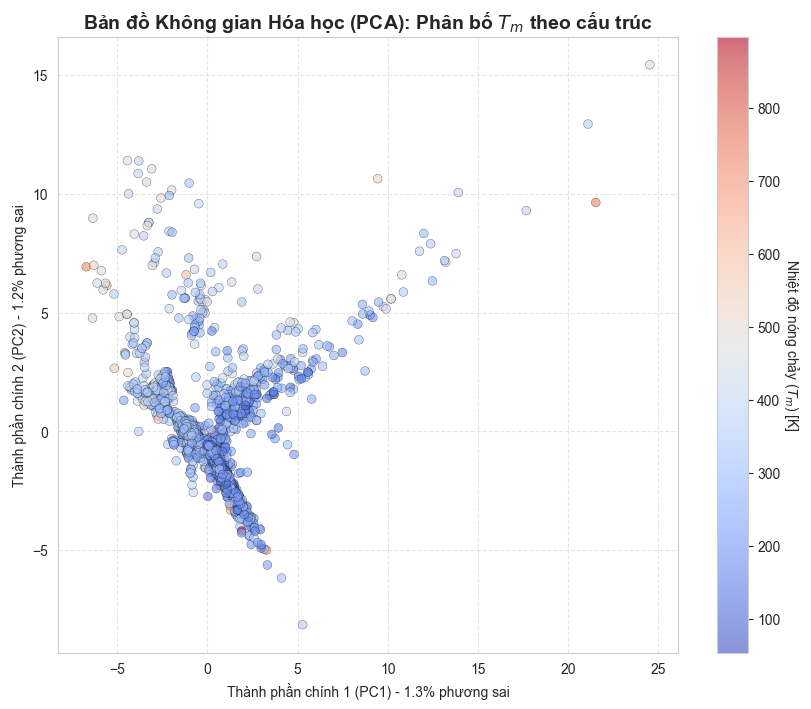

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

group_cols = [c for c in df_train.columns if 'Group' in c]
X = df_train[group_cols]
y = df_train['Tm']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
pca_df['Tm'] = y.values

plt.figure(figsize=(10, 8))
points = plt.scatter(pca_df['PC1'], pca_df['PC2'], 
                     c=pca_df['Tm'], cmap='coolwarm', alpha=0.6, s=40, edgecolor='k', linewidth=0.3)

cbar = plt.colorbar(points)
cbar.set_label('Nhiệt độ nóng chảy ($T_m$) [K]', rotation=270, labelpad=15)

plt.title('Bản đồ Không gian Hóa học (PCA): Phân bố $T_m$ theo cấu trúc', fontsize=14, fontweight='bold')
plt.xlabel(f'Thành phần chính 1 (PC1) - {pca.explained_variance_ratio_[0]:.1%} phương sai')
plt.ylabel(f'Thành phần chính 2 (PC2) - {pca.explained_variance_ratio_[1]:.1%} phương sai')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Sự phân tách: Nếu biểu đồ xuất hiện vùng tập trung nhiều điểm màu đỏ (nhiệt độ cao) và vùng màu xanh (nhiệt độ thấp) tách biệt nhau, điều đó chứng tỏ cấu trúc hóa học (các Groups) có khả năng phân loại điểm nóng chảy rất tốt.

PC1 (Trục hoành): Thường đại diện cho kích thước phân tử (do chiếm phương sai lớn nhất). Các chất nằm càng xa về phía dương của PC1 thường có cấu trúc càng phức tạp.

Ngoại lệ: Các điểm nằm trơ trọi một mình (Outliers) trên bản đồ PCA là những chất có cấu trúc "độc nhất vô nhị" trong tập dữ liệu.

## Giải phẫu các Trường hợp Cực đoan (Extreme Case Analysis)

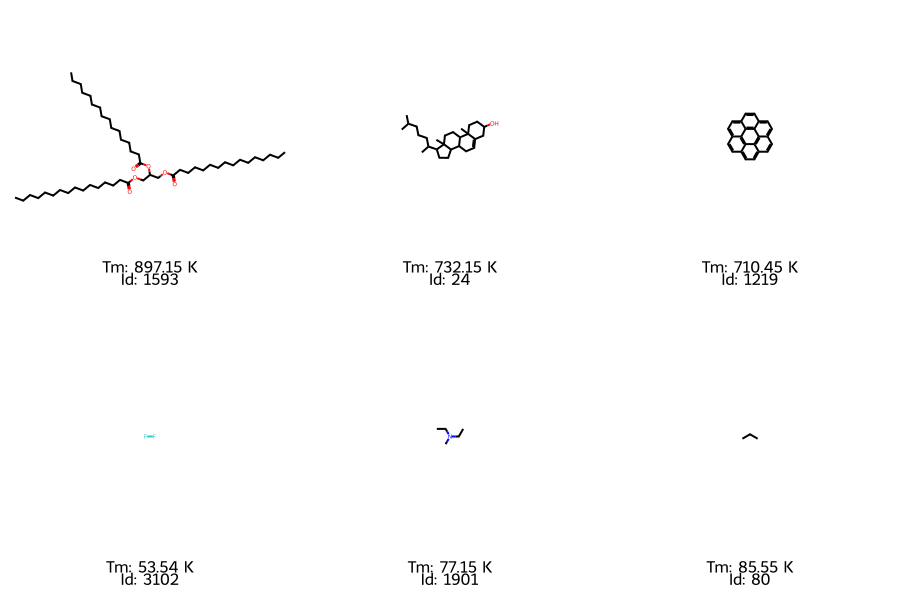

In [11]:
from rdkit.Chem import Draw

top_high_tm = df_train.nlargest(3, 'Tm')
top_low_tm = df_train.nsmallest(3, 'Tm')
extremes = pd.concat([top_high_tm, top_low_tm])

mols = [Chem.MolFromSmiles(s) for s in extremes['SMILES']]
legends = [f"Tm: {tm} K\nId: {i}" for tm, i in zip(extremes['Tm'], extremes['id'])]

img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(300, 300), 
                           legends=legends, returnPNG=False)

display(img)

Nhóm $T_m$ Cao (Hàng trên): Quan sát xem chúng có đặc điểm gì chung? Thường bạn sẽ thấy:
-Nhiều vòng thơm (benzene, naphthalene...) nối với nhau (hệ thống phẳng, xếp chồng tốt).
-Chứa các nhóm phân cực mạnh như Axit (-COOH), Amide (-CONH-) tạo liên kết Hydro.
-Cấu trúc đối xứng cao.

Nhóm $T_m$ Thấp (Hàng dưới):
-Mạch thẳng dài, nhiều nhánh (gây cản trở không gian).
-Ít nhóm chức phân cực.
-Chứa các liên kết Ether (-O-) hoặc Ester (-COO-) làm giảm độ bền mạng tinh thể.

Tổng hợp: Đây là bằng chứng trực quan nhất để khẳng định rằng: Cấu trúc quyết định tính chất.